In [1]:
import xtrack as xt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xpart as xp
import xobjects as xo
import yaml
from matplotlib.ticker import ScalarFormatter
from scipy.fft import rfft


/afs/cern.ch/work/a/aradosla/private/example_DA_study_mine/miniforge/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
ctx = xo.ContextCpu()
collider = xt.Multiline.from_json('/afs/cern.ch/work/a/aradosla/private/example_DA_study_mine/master_study/master_jobs/2_configure_and_track/collider.json')
line = collider['lhcb1']


Loading line from dict: 100%|██████████| 81356/81356 [00:08<00:00, 9950.69it/s] 


Done loading line from dict.           


Loading line from dict: 100%|██████████| 81500/81500 [00:06<00:00, 11992.13it/s]


Done loading line from dict.           


Loading line from dict:  18%|█▊        | 14612/80692 [00:01<00:05, 13212.48it/s]

In [ ]:
line.build_tracker()
tw = line.twiss()

## Exciter in the dipole

# Exciter is working
f = 50
phi = 0
A = 1
sampling_frequency = 11245.5
N_turns = 100
total_time = N_turns / sampling_frequency
time = np.arange(0, total_time, 1/sampling_frequency)
samples = A * np.sin(2*np.pi*f*time + phi)

exciter = xt.Exciter(_context = ctx,
    samples = samples,
    sampling_frequency = sampling_frequency,
    #duration = 0.05,  # defaults to waveform duration   in sec, checked with the number of turns 0.05*11245.5=562.275
    duration= N_turns/sampling_frequency,
    frev = sampling_frequency,
    #start_turn = num_turns/10,  # default, seconds
    #start_turn = 500*1/sampling_frequency ,  
    #knl = [0.00000001],  # default, no kick
    knl = [0.000012]
     # default, no kick
    #knl = [1],
    #ksl = []
)

line.insert_element(
    element = exciter,
    name = 'RF_KO_EXCITER',
    index ='mb.b9r3.b1',
)

In [21]:
collider.build_trackers()

Xcoll not installed, skipping collimator elements


Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


In [22]:
#dir(line)
line['mbw.b6r3.b1_dex']
line.get_table()



Table: 81137 rows, 5 cols

In [23]:
# Filter elements starting with 'mb' and not ending with 'exit' or 'start'
element_names = np.array(line._element_names)
mb_elements = [element for element in element_names if element.startswith('mb.') and element.endswith('.b1')]
# Print the filtered elements
print(len(mb_elements))


1232


In [24]:

N_particles = int(1e4)
bunch_intensity = 2.2e11
normal_emitt_x = 2.5e-6 #m*rad
normal_emitt_y = 2.5e-6 #m*rad
sigma_z = 7.5e-2 
particle_ref = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)
'''
gaussian_bunch = xp.generate_matched_gaussian_bunch(
        num_particles = N_particles, total_intensity_particles = bunch_intensity,
        nemitt_x = normal_emitt_x, nemitt_y=normal_emitt_y, sigma_z = sigma_z,
        particle_ref = particle_ref,
        line = collider['lhcb1'])
'''


"\ngaussian_bunch = xp.generate_matched_gaussian_bunch(\n        num_particles = N_particles, total_intensity_particles = bunch_intensity,\n        nemitt_x = normal_emitt_x, nemitt_y=normal_emitt_y, sigma_z = sigma_z,\n        particle_ref = particle_ref,\n        line = collider['lhcb1'])\n"

In [25]:
# Colored
def parameters(n_part):
    n_sigma = 6.0
    #n_part = config_particles['N_particles']
    
    x  = np.zeros(n_part)
    px = np.zeros(n_part)
    y  = np.zeros(n_part)
    py = np.zeros(n_part)
    z = np.zeros(n_part)

    sigma_d = 7.5e-2
    dp = np.random.uniform(0.1*sigma_d,3.1*sigma_d,n_part)
    return n_sigma, x, px, y, py, z, dp


def cmp_weights(df):
    
    r2 = df['x']**2 + df['px']**2 + df['y']**2 + df['py']**2
    w = np.exp(-r2/2.)
    #r2_l = df['z']**2 + df['dp']**2
    #w *=np.exp(r2_l/2.)
    w/=np.sum(w)
    return w


def generate_pseudoKV_xpyp(i):
  not_generated = True
  n_sigma, x, px, y, py, z, dp = parameters(N_particles)
  while not_generated:
    u = np.random.normal(size=4)
    r = np.sqrt(np.sum(u**2))
    u *= n_sigma/r
    v = np.random.normal(size=4)
    r = np.sqrt(np.sum(v**2))
    v *= n_sigma/r
    R2 = u[0]**2 + u[1]**2 + v[0]**2 + v[1]**2
    if R2 <= n_sigma**2:
        x[i]  = u[0]
        px[i] = u[1]
        y[i]  = v[0]
        py[i] = v[1]
        not_generated = False
  return

def df_colored_func(n_part):
    n_sigma, x, px, y, py, z, dp = parameters(n_part)
    list(map(generate_pseudoKV_xpyp, range(n_part)))
    df = pd.DataFrame({'x':x , 'y': y, 'px': px, 'py': py, 'z': z, 'dp':dp})
    df['weights'] = cmp_weights(df)
    return df




 # %%
# =================================================================================================================================
# Colored gaussian
def generate_matched_gaussian_bunch_colored(num_particles,
                                    nemitt_x, nemitt_y, sigma_z,
                                    total_intensity_particles=None,
                                    particle_on_co=None,
                                    R_matrix=None,
                                    circumference=None,
                                    momentum_compaction_factor=None,
                                    rf_harmonic=None,
                                    rf_voltage=None,
                                    rf_phase=None,
                                    p_increment=0.,
                                    tracker=None,
                                    line=None,
                                    particle_ref=None,
                                    particles_class=None,
                                    engine=None,
                                    _context=None, _buffer=None, _offset=None,
                                    **kwargs, # They are passed to build_particles
                                    ):

    """
    Generate a matched Gaussian bunch.

    Parameters
    ----------
    line : xpart.Line
        Line for which the bunch is generated.
    num_particles : int
        Number of particles to be generated.
    nemitt_x : float
        Normalized emittance in the horizontal plane (in m rad).
    nemitt_y : float
        Normalized emittance in the vertical plane (in m rad).
    sigma_z : float
        RMS bunch length in meters.
    total_intensity_particles : float
        Total intensity of the bunch in particles.

    Returns
    -------
    part : xpart.Particles
        Particles object containing the generated particles.

    """

    if line is not None and tracker is not None:
        raise ValueError(
            'line and tracker cannot be provided at the same time.')

    if tracker is not None:
        print(
            "The argument tracker is deprecated. Please use line instead.",
            DeprecationWarning)
        line = tracker.line

    if line is not None:
        assert line.tracker is not None, ("The line has no tracker. Please use "
                                          "`Line.build_tracker()`")

    if (particle_ref is not None and particle_on_co is not None):
        raise ValueError("`particle_ref` and `particle_on_co`"
                " cannot be provided at the same time")

    if particle_ref is None:
        if particle_on_co is not None:
            particle_ref = particle_on_co
        elif line is not None and line.particle_ref is not None:
            particle_ref = line.particle_ref
        else:
            raise ValueError(
                "`line`, `particle_ref` or `particle_on_co` must be provided!")

    zeta, delta = xp.generate_longitudinal_coordinates(
            distribution='gaussian',
            num_particles=num_particles,
            particle_ref=(particle_ref if particle_ref is not None
                          else particle_on_co),
            line=line,
            circumference=circumference,
            momentum_compaction_factor=momentum_compaction_factor,
            rf_harmonic=rf_harmonic,
            rf_voltage=rf_voltage,
            rf_phase=rf_phase,
            p_increment=p_increment,
            sigma_z=sigma_z,
            engine=engine,
            **kwargs)

    assert len(zeta) == len(delta) == num_particles

    df_colored = df_colored_func(num_particles)

    x_norm = df_colored['x'].values
    px_norm = df_colored['px'].values
    y_norm = df_colored['y'].values
    py_norm = df_colored['py'].values

    if total_intensity_particles is None:
        # go to particles.weight = 1
        total_intensity_particles = num_particles


    part = xp.build_particles(_context=_context, _buffer=_buffer, _offset=_offset,
                      R_matrix=R_matrix,
                      #particles_class=particles_class,
                      particle_on_co=particle_on_co,
                      particle_ref=(
                          particle_ref if particle_on_co is  None else None),
                      line=line,
                      zeta=zeta, delta=delta,
                      x_norm=x_norm, px_norm=px_norm,
                      y_norm=y_norm, py_norm=py_norm,
                      nemitt_x=nemitt_x, nemitt_y=nemitt_y,
                      weight=total_intensity_particles/num_particles,
                      **kwargs)
    return part

# %%

line.build_tracker()
gaussian_bunch = generate_matched_gaussian_bunch_colored(
            num_particles = N_particles, total_intensity_particles =2.2e11,
            nemitt_x = 2.5e-6, nemitt_y= 2.5e-6, sigma_z = 7.5e-2,
            particle_ref = particle_ref,
            line = collider['lhcb1'])

The line already has an associated tracker
*** Maximum RMS bunch length 0.1178949914281685m.
... distance to target bunch length: -7.5000e-02
... distance to target bunch length: 3.9638e-02
... distance to target bunch length: 3.4968e-02
... distance to target bunch length: 8.3248e-03
... distance to target bunch length: -1.1693e-02
... distance to target bunch length: 8.3351e-04
... distance to target bunch length: -2.3601e-05
... distance to target bunch length: 1.8475e-07
... distance to target bunch length: -1.8174e-07
--> Bunch length: 0.07499981825522939
--> Emittance: 1.8429137008416192


Text(0, 0.5, 'z')

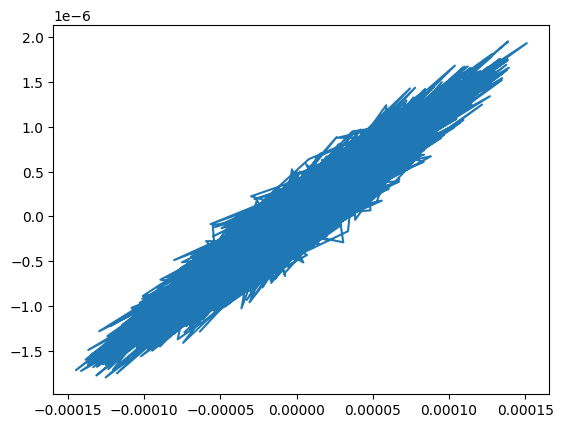

<Figure size 640x480 with 0 Axes>

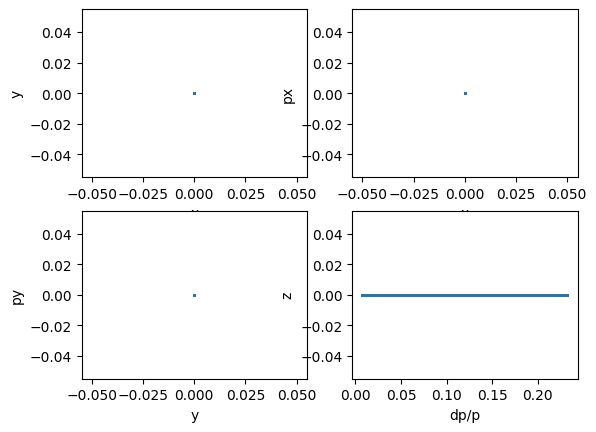

In [26]:
df= df_colored_func(N_particles)
plt.plot(gaussian_bunch.x, gaussian_bunch.px)
plt.figure()
fig, ax = plt.subplots(nrows=2, ncols=2)
plt.sca(ax[0,0])
plt.scatter(df['x'], df['y'], s=1)
plt.ylabel("y")
plt.xlabel("x")

plt.sca(ax[0,1])
plt.scatter(df['x'], df['px'], s=1)
plt.ylabel("px")
plt.xlabel("x")

plt.sca(ax[1,0])
plt.scatter(df['y'], df['py'], s=1)
plt.ylabel("py")
plt.xlabel("y")

plt.sca(ax[1,1])
plt.scatter(df['dp'],df['z'], s=1)
plt.xlabel("dp/p")
plt.ylabel("z")


In [27]:

coord = line.twiss().get_normalized_coordinates(gaussian_bunch, nemitt_x = 2.5e-6, #m*rad
nemitt_y = 2.5e-6) #m*rad)


In [28]:
gaussian_bunch

Particles(_capacity=10000, _num_active_particles=10000, _num_lost_particles=0, start_tracking_at_element=-1, q0=1.0, mass0=938272088.1604904, _p0c=[6.99999994e+12 6.99999994e+12 6.99999994e+12 ... 6.99999994e+12
 6.99999994e+12 6.99999994e+12], _gamma0=[7460.52247352 7460.52247352 7460.52247352 ... 7460.52247352 7460.52247352
 7460.52247352], _beta0=[0.99999999 0.99999999 0.99999999 ... 0.99999999 0.99999999 0.99999999], s=[0. 0. 0. ... 0. 0. 0.], zeta=[-0.04874581  0.00750189  0.02719107 ... -0.03377103 -0.0104061
 -0.00542306], x=[-3.73462837e-05  7.36531082e-06 -9.51237048e-05 ... -6.77570819e-05
 -1.84199235e-07 -4.62213501e-05], y=[ 1.78879198e-05 -2.96799066e-06  3.98989072e-05 ...  3.03039669e-05
  8.33042234e-07  2.02167981e-05], px=[-3.54915870e-07  8.89067476e-08 -1.25046386e-06 ... -7.72125486e-07
  3.21916448e-08 -5.61075411e-07], py=[ 1.83115858e-07 -2.13779225e-08  4.36061348e-07 ...  3.18153627e-07
  1.37904957e-08  2.19561870e-07], _ptau=[ 6.28246233e-05 -1.41774706e-05

tw0 = collider.lhcb1.twiss()
gamma_rel = float(line.particle_ref.gamma0[0])
betx_rel = float(line.particle_ref.beta0[0])
betx = tw0.betx[0]

norm_emit = normal_emitt_x
aperture = np.arange(2, 0, -0.01)
survived = []

sigmax_col = np.sqrt(norm_emit / gamma_rel * betx)  # geom_emit = norm_emit / gamma_rel
current_turn = 0
for current_aperture in aperture:
    current_df = coord
    #current_df = coord[coord["turns"] == current_turn]
    initial_number_of_particles = len(current_df)
    current_df = current_df[(current_df["x_norm"]**2 + (current_df["px_norm"])**2) * 100 < (current_aperture)**2]
    survived.append(100 - len(current_df)/initial_number_of_particles*100.)
fig, ax = plt.subplots()
plt.plot(aperture, survived, lw=4, label = 'Suvived')
plt.plot(aperture, [np.exp(-x**2/2.0)*100. for x in aperture], c='r', linestyle='--', lw=2)
plt.xlabel('Sigma')

plt.ylabel('Survived particles %')
len(coord)

In [29]:

tw0 = collider.lhcb1.twiss()
gamma_rel = float(line.particle_ref.gamma0[0])
betx_rel = float(line.particle_ref.beta0[0])
betx = tw0.betx[0]

norm_emit = normal_emitt_x
coord.show()


particle_id at_element       x_norm     px_norm      y_norm    py_norm    zeta_norm   pzeta_norm
          0          0  -0.00330399 -0.00773385  0.00130456 0.00554269  -0.00173283   0.00175705
          1          0   -0.0038447 -0.00736317  0.00156615 0.00505183  0.000266674 -0.000400384
          2          0   -0.0040936 -0.00724067  0.00178508 0.00503708  0.000966589    0.0050083
          3          0  -0.00337713 -0.00766035  0.00129213  0.0053738  -0.00135535  -0.00164154
          4          0  -0.00339568 -0.00769313  0.00139425 0.00555663  -0.00149521   0.00433682
          5          0  -0.00363728 -0.00752575  0.00150753  0.0053296 -0.000593762   0.00313922
          6          0  -0.00363305 -0.00750226  0.00145145  0.0052176 -0.000488468 -0.000355129
          7          0  -0.00364573 -0.00746693  0.00140308 0.00508923 -0.000319577  -0.00394782
          8          0  -0.00389481  -0.0073196  0.00157152 0.00496589   0.00049419  -0.00182652
          9          0  -0.003

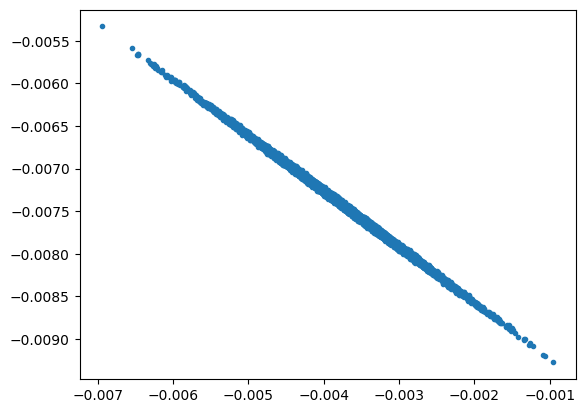

In [30]:
plt.plot(coord.x_norm, coord.px_norm, '.')

In [31]:
coord.x_norm[coord.x_norm**2 + coord.px_norm**2 > 2]
gaussian_bunch.beta0[0]
line.twiss().betx[0]

114.44393533389758

Text(0, 0.5, 'Survived particles %')

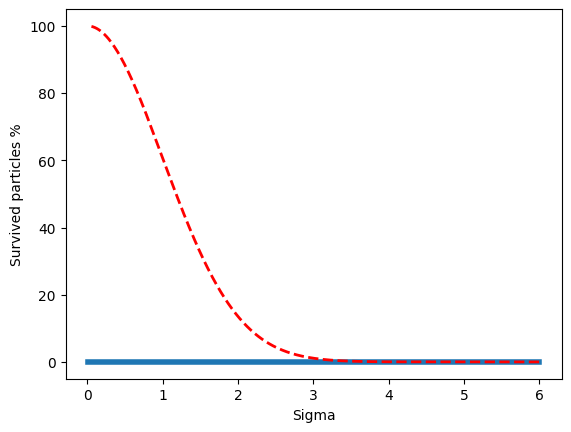

In [32]:

sigmax_col = np.sqrt(norm_emit / gamma_rel * betx)  # geom_emit = norm_emit / gamma_rel
aperture = np.arange(6, 0, -0.01)
survived = []
current_turn = 0
for current_aperture in aperture:
    current_df = coord
    #current_df = coord[coord["turns"] == current_turn]
    initial_number_of_particles = len(current_df)
    current_df = coord.x_norm[(coord.x_norm**2 + coord.px_norm**2) < (current_aperture)**2]
    survived.append(100 - len(current_df)/initial_number_of_particles*100.)
fig, ax = plt.subplots()
plt.plot(aperture, survived, lw=4, label = 'Suvived')
plt.plot(aperture, [np.exp(-x**2/2.0)*100. for x in aperture], c='r', linestyle='--', lw=2)
plt.xlabel('Sigma')

plt.ylabel('Survived particles %')


In [33]:



# Convert the bunch data to a DataFrame
# Convert the bunch data to a dictionary


pd.DataFrame(gaussian_bunch.to_dict()).to_parquet("input_particles.parquet")

gaus = pd.read_parquet('input_particles.parquet')


In [34]:
# Import the parquet gaussian bunch

#gaus = pd.read_parquet('gaussian_bunch.parquet')
#line.track(gaus,  num_turns = N_turns, turn_by_turn_monitor=True, freeze_longitudinal=True)

Text(0.5, 1.0, 'Closed orbit')

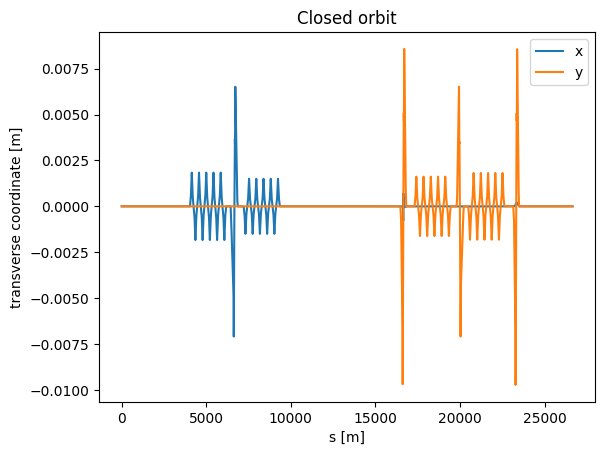

In [35]:

fig, ax = plt.subplots()
plt.plot(tw0.s, tw0.x, label='x')
plt.plot(tw0.s, tw0.y, label='y')
plt.legend()
plt.xlabel('s [m]')
plt.ylabel('transverse coordinate [m]')
plt.title('Closed orbit')

In [36]:
len(gaussian_bunch.state)

10000

In [37]:

N_turns = 100
print("Start")
print(gaussian_bunch)
x_tot =           []
y_tot =           []
px_tot =          []
py_tot =          []
delta_tot =       []
zeta_tot =        []
turns_tot =       []
particle_id_tot = []
pzeta_tot =       []


x_phys =          []
y_phys =          []
zeta_phys =       []
px_phys =         []
py_phys =         []
pzeta_phys =      []
state_all =       []

for i in range(N_turns):
    line.track(gaussian_bunch, num_turns = 1, turn_by_turn_monitor=True, freeze_longitudinal=True)
    print(f"Turn {i}")
    #print(gaussian_bunch)
    x_phys.append(np.copy(gaussian_bunch.x))
    #print(gaussian_bunch.y[0:10])to reduction operation minimum which h
    y_phys.append(np.copy(gaussian_bunch.y))
    zeta_phys.append(np.copy(gaussian_bunch.zeta))
    px_phys.append(np.copy(gaussian_bunch.px))
    py_phys.append(np.copy(gaussian_bunch.py))
    pzeta_phys.append(np.copy(gaussian_bunch.pzeta))
    state_all.append(np.copy(gaussian_bunch.state))
    coord = line.twiss().get_normalized_coordinates(gaussian_bunch, nemitt_x = 2.5e-6, #m*rad
    
    nemitt_y = 2.5e-6) #m*rad)
    x_tot.append(coord.x_norm)
    y_tot.append(coord.y_norm)
    zeta_tot.append(coord.zeta_norm)
    px_tot.append(coord.px_norm)
    py_tot.append(coord.py_norm)
    pzeta_tot.append(coord.pzeta_norm)
    turns_tot.append(np.ones(len(coord.x_norm))*i)
    particle_id_tot.append(coord.particle_id)


Start
Particles(_capacity=10000, _num_active_particles=10000, _num_lost_particles=0, start_tracking_at_element=-1, q0=1.0, mass0=938272088.1604904, _p0c=[6.99999994e+12 6.99999994e+12 6.99999994e+12 ... 6.99999994e+12
 6.99999994e+12 6.99999994e+12], _gamma0=[7460.52247352 7460.52247352 7460.52247352 ... 7460.52247352 7460.52247352
 7460.52247352], _beta0=[0.99999999 0.99999999 0.99999999 ... 0.99999999 0.99999999 0.99999999], s=[0. 0. 0. ... 0. 0. 0.], zeta=[-0.04874581  0.00750189  0.02719107 ... -0.03377103 -0.0104061
 -0.00542306], x=[-3.73462837e-05  7.36531082e-06 -9.51237048e-05 ... -6.77570819e-05
 -1.84199235e-07 -4.62213501e-05], y=[ 1.78879198e-05 -2.96799066e-06  3.98989072e-05 ...  3.03039669e-05
  8.33042234e-07  2.02167981e-05], px=[-3.54915870e-07  8.89067476e-08 -1.25046386e-06 ... -7.72125486e-07
  3.21916448e-08 -5.61075411e-07], py=[ 1.83115858e-07 -2.13779225e-08  4.36061348e-07 ...  3.18153627e-07
  1.37904957e-08  2.19561870e-07], _ptau=[ 6.28246233e-05 -1.417747

e23247e5a73e44d1865abea8d48942c5.c:5371: warning: "_GNU_SOURCE" redefined
 5371 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from e23247e5a73e44d1865abea8d48942c5.c:50:
/afs/cern.ch/work/a/aradosla/private/example_DA_study_mine/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 
e23247e5a73e44d1865abea8d48942c5.c: In function ‘compt_do’:
e23247e5a73e44d1865abea8d48942c5.c:18541:12: warning: unused variable ‘e_loss_primary_tot’ [-Wunused-variable]
18541 |     double e_loss_primary_tot = 0.0;  // [GeV] total energy lost by the macroparticle
      |            ^~~~~~~~~~~~~~~~~~
e23247e5a73e44d1865abea8d48942c5.c:18538:62: warning: variable ‘ps_e_prime’ set but not used [-Wunused-but-set-variable]
18538 |     double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
      |                

Done compiling ContextCpu kernels.
Turn 0
Turn 1
Turn 2
Turn 3
Turn 4
Turn 5
Turn 6
Turn 7
Turn 8
Turn 9
Turn 10
Turn 11
Turn 12
Turn 13
Turn 14
Turn 15
Turn 16
Turn 17
Turn 18
Turn 19
Turn 20
Turn 21
Turn 22
Turn 23
Turn 24
Turn 25
Turn 26
Turn 27
Turn 28
Turn 29
Turn 30
Turn 31
Turn 32
Turn 33
Turn 34
Turn 35
Turn 36
Turn 37
Turn 38
Turn 39
Turn 40
Turn 41
Turn 42
Turn 43
Turn 44
Turn 45
Turn 46
Turn 47
Turn 48
Turn 49
Turn 50
Turn 51
Turn 52
Turn 53
Turn 54
Turn 55
Turn 56
Turn 57
Turn 58
Turn 59
Turn 60
Turn 61
Turn 62
Turn 63
Turn 64
Turn 65
Turn 66
Turn 67
Turn 68
Turn 69
Turn 70
Turn 71
Turn 72
Turn 73
Turn 74
Turn 75
Turn 76
Turn 77
Turn 78
Turn 79
Turn 80
Turn 81
Turn 82
Turn 83
Turn 84
Turn 85
Turn 86
Turn 87
Turn 88
Turn 89
Turn 90
Turn 91
Turn 92
Turn 93
Turn 94
Turn 95
Turn 96
Turn 97
Turn 98
Turn 99


10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000


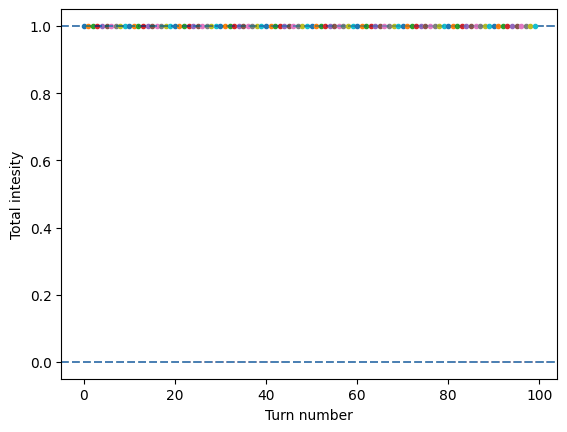

In [38]:
for turn in range(len(state_all)):
    
    plt.plot(turn, (np.sum(state_all[turn])/2+5000)/N_particles, '.')
    plt.axhline(0, linestyle = 'dashed', alpha = 0.01)
    plt.axhline(N_particles/N_particles, linestyle = 'dashed', alpha = 0.01)
    print(np.sum(state_all[turn]))
    plt.xlabel("Turn number")
    plt.ylabel("Total intesity")

#state_all_noexcitation = state_all
#plt.plot(state_all_noexcitation)

Text(0, 0.5, 'State of particle')

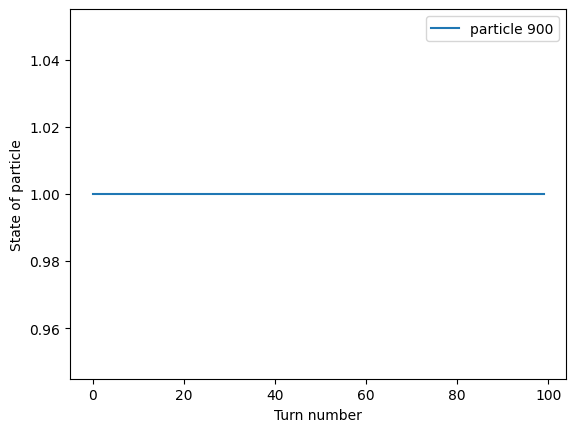

In [39]:
plt.plot(np.array(state_all).T[900], label = 'particle 900')
plt.legend()
plt.xlabel("Turn number")
plt.ylabel("State of particle")


In [40]:
x_physflat = [item for sublist in x_phys for item in sublist]
y_physflat = [item for sublist in y_phys for item in sublist]
zeta_physflat = [item for sublist in zeta_phys for item in sublist]
px_physflat = [item for sublist in px_phys for item in sublist]
py_physflat = [item for sublist in py_phys for item in sublist]
pzeta_physflat = [item for sublist in pzeta_phys for item in sublist]
state_allflat = [item for sublist in state_all for item in sublist]

x_normflat = [item for sublist in x_tot for item in sublist]
y_normflat = [item for sublist in y_tot for item in sublist]
zeta_normflat = [item for sublist in zeta_tot for item in sublist]
px_normflat = [item for sublist in px_tot for item in sublist]
py_normflat = [item for sublist in py_tot for item in sublist]
pzeta_normflat = [item for sublist in pzeta_tot for item in sublist]

particle_id_flat = [item for sublist in particle_id_tot for item in sublist]
turns_flat = [item for sublist in turns_tot for item in sublist]


print(len(x_physflat))
print(x_tot)

1000000
[array([-0.00349909, -0.00387068, -0.01046964, ..., -0.00593437,
       -0.00368273, -0.00507703]), array([-0.00336704, -0.00389152, -0.01182246, ..., -0.00661012,
       -0.00367728, -0.00539484]), array([-0.00324519, -0.00385401, -0.00467153, ..., -0.00375895,
       -0.00366667, -0.00388154]), array([-0.00344135, -0.00385395, -0.00738156, ..., -0.00469582,
       -0.00367808, -0.00441008]), array([-0.00345701, -0.00389149, -0.01300047, ..., -0.00702228,
       -0.00368239, -0.00562892]), array([-0.00325348, -0.00387075, -0.00709215, ..., -0.00476558,
       -0.00366849, -0.00441783]), array([-0.00334717, -0.00384471, -0.00482522, ..., -0.00371206,
       -0.00367193, -0.00387554]), array([-0.00350023, -0.00387987, -0.01203196, ..., -0.00657194,
       -0.00368401, -0.00539157]), array([-0.00332398, -0.00388643, -0.01020268, ..., -0.00600682,
       -0.00367378, -0.00508578]), array([-0.0032653 , -0.00384764, -0.00402415, ..., -0.0034588 ,
       -0.00366735, -0.00373896]), a

## Noise simulation data reading

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#noise_data = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim62.31-60.32/*/*')
noise_data = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_try_62.32_61.32_1000/*/*')
#noise_data = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_try/*/*')
#print(noise_data)
df_xnorm = []
df_atturn = []

for file in noise_data:
    #print(file)
    file = pd.read_parquet(file)
    df_xnorm.append(file['x_norm'])
    df_atturn.append(file['at_turn'])
    #turns = np.unique(file['at_turn'].values)
    #plt.plot(file[file['at_turn'] == 0]['x'], file[file['at_turn'] == 0]['px'], '.', color = 'b') 
    #plt.plot(file[file['at_turn'] == 99]['x'], file[file['at_turn'] == 99]['px'], '.', color = 'r') 
    #plt.plot(file[file['at_turn'] == turns[0]]['x_norm'], file[file['at_turn'] == turns[0]]['px_norm'], '.', color = 'b') 
    #plt.plot(file[file['at_turn'] == turns[-1]]['x_norm'], file[file['at_turn'] == turns[-1]]['px_norm'], '.', color = 'r') 


In [5]:
display(file)

,particle_id,at_turn,state,x_phys,y_phys,zeta_phys,px_phys,py_phys,pzeta_phys,x_norm,y_norm,zeta_norm,px_norm,py_norm,pzeta_norm,norm_emitx,norm_emity
0,0,0.0,1,-0.000283,-0.000109,-0.053687,5.946647e-06,-2.715746e-06,-0.000118,-1.914045,-0.636475,-0.001908,-0.779728,-1.008804,-0.003337,0.000006,0.000002
1,1,0.0,1,-0.000221,-0.000077,0.006594,3.187088e-06,-1.312946e-06,0.000087,-0.914767,-0.436161,0.000235,0.343922,-0.141442,0.002435,0.000006,0.000002
2,2,0.0,1,0.000101,0.000031,0.050264,-1.273197e-07,-3.870902e-07,0.000010,0.445720,0.336524,0.001787,1.268659,-0.578100,0.000282,0.000006,0.000002
3,3,0.0,1,0.000091,-0.000145,0.025968,-2.282973e-06,-3.130968e-06,-0.000041,0.256203,-0.589864,0.000923,-0.574247,-1.277705,-0.001162,0.000006,0.000002
4,4,0.0,1,-0.000268,-0.000467,-0.050536,3.391385e-06,-6.683394e-06,-0.000030,-1.390381,-2.150610,-0.001796,-1.058890,-0.800859,-0.000853,0.000006,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5,999.0,1,-0.000541,-0.000329,-0.016730,6.483711e-06,-4.028399e-06,0.000103,-2.391064,-1.810000,-0.000594,-1.105811,0.183955,0.002901,0.000006,0.000001
9996,6,999.0,1,0.000126,0.000241,0.036570,-7.211836e-06,1.115173e-06,0.000081,0.600133,0.703405,0.001300,-2.049727,-1.774839,0.002291,0.000006,0.000001
9997,7,999.0,1,-0.000480,0.000136,0.024015,8.731613e-06,1.859982e-06,0.000013,-2.514432,0.261395,0.000854,-0.239658,0.506533,0.000377,0.000006,0.000001
9998,8,999.0,1,0.000066,0.000143,0.129854,-3.442310e-06,4.433293e-07,0.000079,0.338870,0.514629,0.004616,-0.435328,-1.179184,0.002241,0.000006,0.000001


In [3]:
x_all = pd.concat(df_xnorm, ignore_index=True)
turn_all = pd.concat(df_atturn, ignore_index=True)
all = pd.concat([x_all, turn_all], axis=1)


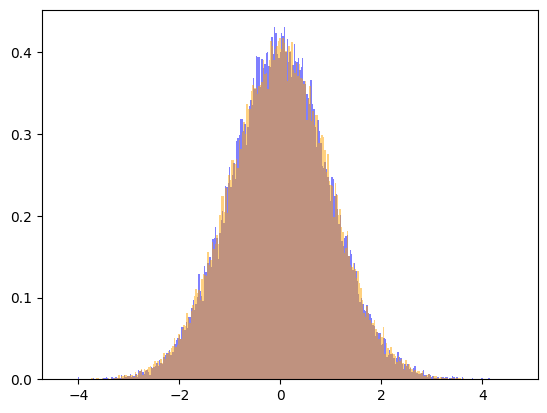

In [4]:
'''
for file in noise_data:
    #print(file)
    file = pd.read_parquet(file)
    turns = np.unique(file['at_turn'].values)
    #plt.plot(file[file['at_turn'] == turns[0]]['x'], file[file['at_turn'] == turns[0]['px'], '.', color = 'b') 
    plt.hist(file[file['at_turn'] == turns[0]]['x_norm'], bins=100)
    plt.hist(file[file['at_turn'] == turns[-1]]['x_norm'], bins =100)
'''
turns = np.unique(all['at_turn'])
plt.figure()
plt.hist(all[all['at_turn']==turns[0]]['x_norm'], bins=300, color='blue', alpha = 0.5,  density=True)
plt.hist(all[all['at_turn']==turns[-1]]['x_norm'], bins=300, color = 'orange', alpha = 0.5,  density=True)
plt.show()

4944

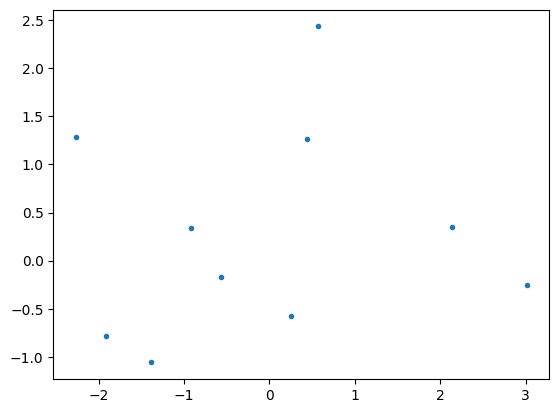

In [73]:
#plt.plot(file['x'].values, file['px'].values)
generate_matched_gaussian_bunch_colored
#plt.plot(file[file['at_turn'] == 0]['x'], file[file['at_turn'] == 0]['px'], '.') 
plt.plot(file[file['at_turn'] == 0]['x_norm'], file[file['at_turn'] == 0]['px_norm'], '.') 
file.keys()
len(noise_data)

In [42]:
dictionary = {"particle_id": particle_id_flat, "at_turn": turns_flat, "state":state_allflat, "x_phys": x_physflat, "y_phys": y_physflat, "zeta_phys": zeta_physflat, "px_phys": px_physflat, "py_phys": py_physflat, "pzeta_phys": pzeta_physflat, "x_norm": x_normflat, "y_norm": y_normflat, "zeta_norm": zeta_normflat, "px_norm": px_normflat, "py_norm": py_normflat, "pzeta_norm": pzeta_normflat}
result_phys = pd.DataFrame(dictionary)

In [28]:
print(result_phys[result_phys['at_turn'] == 0].y_phys[:10])
print(result_phys[result_phys['at_turn'] == 2].y_phys[:10])

0   -0.000033
1    0.000022
2    0.000039
3   -0.000007
4    0.000016
5    0.000029
6   -0.000008
7   -0.000034
8    0.000006
9   -0.000008
Name: y_phys, dtype: float64
20000   -0.000032
20001    0.000022
20002    0.000040
20003   -0.000005
20004    0.000016
20005    0.000029
20006   -0.000007
20007   -0.000034
20008    0.000006
20009   -0.000005
Name: y_phys, dtype: float64


In [29]:
# Emittance

geomx_all_std = []
geomy_all_std = []
normx_all_std = []
normy_all_std = []


for turn in range(N_turns):
    print(turn)
    sigma_delta = float(np.std(result_phys[result_phys['at_turn'] == turn].pzeta_phys))
    sigma_x = float(np.std(result_phys[result_phys['at_turn'] == turn].x_phys))
    sigma_y = float(np.std(result_phys[result_phys['at_turn'] == turn].y_phys))
    
    geomx_emittance = (sigma_x**2-(tw0[:,0]["dx"][0]*sigma_delta)**2)/tw0[:,0]["betx"][0]
    
    normx_emittance = geomx_emittance*(gamma_rel*betx_rel)
    #print(normy_emittance)
    geomx_all_std.append(geomx_emittance)
    normx_all_std.append(normx_emittance)

    geomy_emittance = (sigma_y**2-(tw0[:,0]["dy"][0]*sigma_delta)**2)/tw0[:,0]["bety"][0]
    normy_emittance = geomy_emittance*(gamma_rel*betx_rel)
    geomy_all_std.append(geomy_emittance)
    normy_all_std.append(normy_emittance)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [30]:
normx_all_std[3]

9.866757362958244e-10

In [31]:
pd.set_option('float_format', '{:.10f}'.format) 
for i in range(N_turns):
    mask = result_phys["at_turn"] == i
    result_phys.loc[mask, 'norm_emitx'] = normx_all_std[i] * np.ones(mask.sum())
    result_phys.loc[mask, 'norm_emity'] = normy_all_std[i] * np.ones(mask.sum())


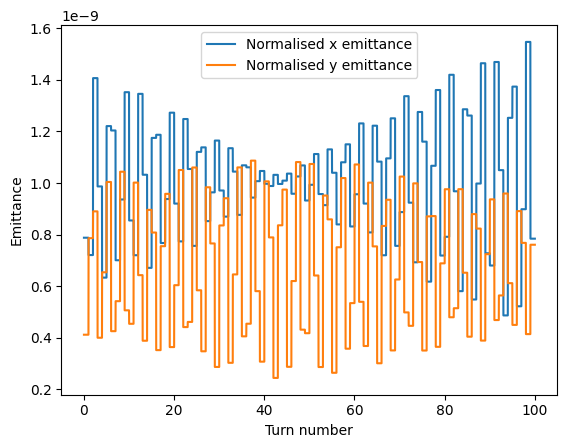

In [32]:
plt.plot(np.arange(len(result_phys[result_phys['state']==1]['norm_emitx']))/N_particles, result_phys[result_phys['state']==1]['norm_emitx'], label = 'Normalised x emittance')
plt.plot(np.arange(len(result_phys[result_phys['state']==1]['norm_emitx']))/N_particles, result_phys[result_phys['state']==1]['norm_emity'], label = 'Normalised y emittance')
plt.xlabel('Turn number')
plt.ylabel('Emittance')
#plt.xlim(0,14)

#plt.ylim(0,1e-4)
plt.legend()

In [33]:
print(np.unique(result_phys[result_phys['state']==1]['norm_emitx']))

[4.86524199e-10 5.21950174e-10 5.48259695e-10 5.80656957e-10
 6.17567601e-10 6.33069100e-10 6.70895404e-10 6.80010622e-10
 6.92505023e-10 7.00423533e-10 7.18689450e-10 7.19794579e-10
 7.19912662e-10 7.20588635e-10 7.27482994e-10 7.56180540e-10
 7.56214465e-10 7.67296705e-10 7.73561175e-10 7.84116457e-10
 7.87812261e-10 7.91394878e-10 8.08365824e-10 8.31425308e-10
 8.39398828e-10 8.52170711e-10 8.54692072e-10 8.69603530e-10
 8.76382957e-10 8.87182696e-10 8.98335035e-10 9.14072938e-10
 9.20136252e-10 9.20171066e-10 9.23661863e-10 9.32079377e-10
 9.36036891e-10 9.37806334e-10 9.43393961e-10 9.56315024e-10
 9.57078683e-10 9.58283717e-10 9.63725778e-10 9.67830179e-10
 9.70861797e-10 9.86675736e-10 9.88280882e-10 9.93012892e-10
 9.96194870e-10 9.96927076e-10 9.97863446e-10 1.00709057e-09
 1.00915221e-09 1.02529179e-09 1.03155555e-09 1.03195754e-09
 1.03636497e-09 1.03964370e-09 1.04411018e-09 1.04651572e-09
 1.04979207e-09 1.05424265e-09 1.06075923e-09 1.06667293e-09
 1.06806216e-09 1.068455

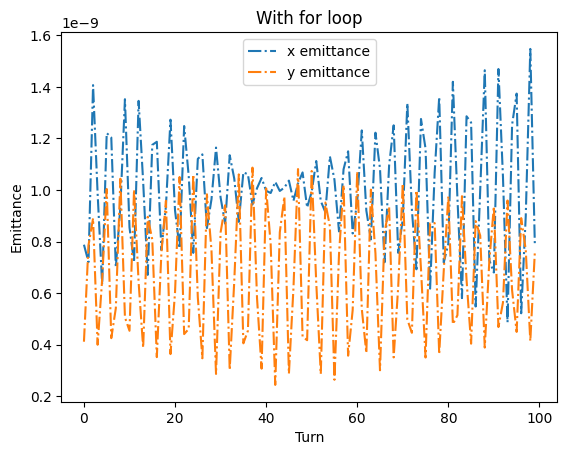

In [34]:
plt.plot(np.arange(N_turns), normx_all_std, '-.', label = 'x emittance')
plt.plot(np.arange(N_turns), normy_all_std, '-.', label = 'y emittance')
plt.xlabel('Turn')
plt.ylabel('Emittance')
plt.title('With for loop')
plt.legend()

In [35]:
line.track(gaussian_bunch,  num_turns = 100, turn_by_turn_monitor=True, freeze_longitudinal=True)


In [ ]:
state = line.record_last_track.state
for i in range(len(state)):
    plt.figure()
    plt.plot(state[i])
    plt.xlabel('Turn')
    plt.ylabel('state')
    plt.show()

In [ ]:

xall = line.record_last_track.x
yall = line.record_last_track.y
zetaall = line.record_last_track.zeta
pzetaall = line.record_last_track.pzeta
pxall = line.record_last_track.px
pyall = line.record_last_track.py


In [ ]:
xall.T[0].shape

In [ ]:
# Emittance

geomx_all_std_try= []
geomy_all_std_try = []
normx_all_std_try = []
normy_all_std_try = []

for turn in range(N_turns):
    print(turn)
    sigma_delta = float(np.std(pzetaall.T[turn]))
    sigma_x = float(np.std(xall.T[turn]))
    sigma_y = float(np.std(yall.T[turn]))
    
    geomx_emittance = (sigma_x**2-(tw0[:,0]["dx"][0]*sigma_delta)**2)/tw0[:,0]["betx"][0]
    
    normx_emittance = geomx_emittance*(gamma_rel*betx_rel)
    print(normx_emittance)
    geomx_all_std_try.append(geomx_emittance)
    normx_all_std_try.append(normx_emittance)

    geomy_emittance = (sigma_y**2-(tw0[:,0]["dy"][0]*sigma_delta)**2)/tw0[:,0]["bety"][0]
    normy_emittance = geomy_emittance*(gamma_rel*betx_rel)
    geomy_all_std_try.append(geomy_emittance)
    normy_all_std_try.append(normy_emittance)

0


NameError: name 'pzetaall' is not defined

In [ ]:
plt.plot(np.arange(N_turns), normx_all_std_try, '-.', label = 'x emittance')
plt.plot(np.arange(N_turns), normy_all_std_try, '-.', label ='y emittance')
plt.xlabel('Turn')
plt.ylabel('Emittance')
plt.title('Turn by turn monitor')
plt.legend()


In [ ]:
result_phys

In [ ]:

survived = []

def scrapping(current_turn):
    survived = []
    for current_aperture in aperture:
        current_df = result_phys[result_phys['at_turn'] == current_turn]
        initial_number_of_particles = len(current_df)
        current_df = current_df[(current_df.x_norm**2 + current_df.px_norm**2) < (current_aperture) ** 2]
        survived.append(100 - len(current_df) / initial_number_of_particles * 100.)
    fig, ax = plt.subplots()
    plt.plot(aperture, survived, lw=4, label = 'Suvived')
    plt.plot(aperture, [np.exp(-x**2/2.0) * 100. for x in aperture], c='r', linestyle='--', lw=2)
    plt.xlabel('Sigma')
    plt.title(f'Scrapping at turn {current_turn}')
    plt.ylabel('Survived particles %')
    plt.show()


scrapping(current_turn=0)
scrapping(current_turn=9)


In [ ]:
plt.plot(result_phys[result_phys['at_turn'] == 0].x_norm, result_phys[result_phys['at_turn'] == 0].px_norm, '.', label = 'Turn 0')
plt.plot(result_phys[result_phys['at_turn'] == 9].x_norm, result_phys[result_phys['at_turn'] == 9].px_norm, '.', label = 'Turn 9')
plt.title('Emittance in the normalised phase space')
plt.xlabel('x normalised')
plt.ylabel('y normalised')
plt.legend()

In [ ]:
print(np.sum(np.square(current_df["x_norm"].values)))
gaussian_bunch.x
gaussian_bunch.y
gaussian_bunch.px 
gaussian_bunch.py 
gaussian_bunch.zeta 
gaussian_bunch.delta
gaussian_bunch.pzeta
gaussian_bunch.particle_id
gaussian_bunch.state

In [ ]:
turn = 0
plt.plot(result_phys[result_phys['particle_id'] == turn].x_norm, result_phys[result_phys['particle_id'] == turn].px_norm, '.')

In [ ]:
line.twiss().get_normalized_coordinates(gaussian_bunch, nemitt_x = 2.5e-6, nemitt_y = 2.5e-6)



In [ ]:
x = line.record_last_track.x  # (particles, turns)
fft = np.fft.fft(x[0])
fft = fft/len(fft)*2
frequencies = np.linspace(0, 11245.5, len(x[0]))



In [ ]:
plt.plot(frequencies, abs(fft))
plt.xlim(0,100)
plt.xlabel('f Hz')
plt.ylabel('Amplitude au')

In [ ]:
def build_particle_distribution(gaussian_bunch1x, gaussian_bunch1y):
    # Define radius distribution
    #r_min = config_particles["r_min"]
    #r_max = config_particles["r_max"]
    #n_r = config_particles["n_r"]
    #radial_list = np.linspace(r_min, r_max, n_r, endpoint=False)

    # Filter out particles with low and high amplitude to accelerate simulation
    # radial_list = radial_list[(radial_list >= 4.5) & (radial_list <= 7.5)]

    # Define angle distribution
    #n_angles = config_particles["n_angles"]
    #theta_list = np.linspace(0, 90, n_angles + 2)[1:-1]

    # Define particle distribution as a cartesian product of the above
    particle_list = [
        (particle_id, y, x)
        for particle_id, x, y in zip(range(len(gaussian_bunch1x)), gaussian_bunch1x, gaussian_bunch1y)
    ]
    
    # Split distribution into several chunks for parallelization
    n_split = 1
    particle_list = list(np.array_split(particle_list, n_split))

    # Return distribution
    return particle_list

In [ ]:
part = build_particle_distribution(gaussian_bunch.x, gaussian_bunch.y)

In [ ]:
plt.plot(np.array(part).T[:][1], np.array(part).T[:][2], '.')

In [ ]:
N_particles = int(1e4) #int(1e6)


bunch_intensity = 2.2e11
normal_emitt_x = 2.5e-6 #m*rad
normal_emitt_y = 2.5e-6 #m*rad
sigma_z = 7.5e-2 
particle_ref = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)
gaussian_bunch = xp.generate_matched_gaussian_bunch(
        num_particles = N_particles, total_intensity_particles = bunch_intensity,
        nemitt_x = normal_emitt_x, nemitt_y=normal_emitt_y, sigma_z = sigma_z,
        particle_ref = particle_ref,
        line = collider['lhcb1'])



In [ ]:
# Define particle distribution as a cartesian product of the above
particle_list = [
    (particle_id, x, y, px, py, zeta, pzeta, delta)
    for particle_id, (x, y, px, py, zeta, pzeta, delta) in enumerate(zip(gaussian_bunch.x, gaussian_bunch.y, gaussian_bunch.px, gaussian_bunch.py, gaussian_bunch.zeta, gaussian_bunch.pzeta, gaussian_bunch.delta))
]
print('first',particle_list)
# Split distribution into several chunks for parallelization
n_split = 4
particle_list = np.array(np.array_split(particle_list, n_split))
array_of_lists = np.array([arr.tolist() for arr in particle_list])
particle_list = array_of_lists
print('second',particle_list)

In [ ]:
import os
import pandas as pd

# Define the directory path where you want to save the Parquet files
test_dir = '/afs/cern.ch/user/a/aradosla/example_DA_study_mine/master_study/master_jobs/1_build_distr_and_collider'

# Create the directory if it doesn't exist
os.makedirs(test_dir, exist_ok=True)

# Assuming 'particle_list' is defined somewhere in your code
for idx_chunk, my_list in enumerate(particle_list):
    # Assuming 'distribution_folder' is another variable containing the folder name
    distribution_folder = 'test_dir'
    
    # Save the chunk data as a Parquet file
    pd.DataFrame(
        my_list,
        columns=["particle_id", "x", "y", "px", "py", "zeta", "pzeta", "delta"]
    ).to_parquet(os.path.join(test_dir, distribution_folder, f"{idx_chunk:02}.parquet"))


In [ ]:
!pwd


In [ ]:
import pandas as pd
result_output = pd.read_parquet('/eos/user/a/aradosla/SWAN_projects/Noise_sim_try/output_particles_new.parquet')

In [ ]:
display(result_output)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(result_output[result_output['at_turn']==0].x_norm, result_output[result_output['at_turn']==0].px_norm, '.' )